# Required spread for different BESS CAPEX

## Import libraries 

In [1]:
# Import required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
from scipy.optimize import fsolve
from statsmodels.formula.api import ols

plt.style.use('ggplot')
%matplotlib inline

## Set up parameters

In [6]:
Actual_capex = 700
charge_price_to_test = 20

# Input parameters
params = {
    'RTE': 0.85,  # Round trip efficiency, applied on the charge cycle
    'degradation_rate': 0.03,  # Degradation rate per year
    'DoD': 0.90,  # Depth of discharge percentage
    'cycles_per_day': 1.5,
    'OPEX': 10,  # $/kWh
    'interest_rate': 0.07,  # Paid monthly
    'project_duration': 15,  # Years
    'initial_capacity': 1.0, # Using 1MWh so everthing scales up by MWh
    'IRR': 0.12  # Goal internal rate of return
}

print(f"CAPEX of BESS to be tested: ${Actual_capex}")
print(f"The assumbed charging price of the BESS ${charge_price_to_test}")
params

CAPEX of BESS to be tested: $700
The assumbed charging price of the BESS $20


{'RTE': 0.85,
 'degradation_rate': 0.03,
 'DoD': 0.9,
 'cycles_per_day': 1.5,
 'OPEX': 10,
 'interest_rate': 0.07,
 'project_duration': 15,
 'initial_capacity': 1.0,
 'IRR': 0.12}

## Calculate daily spread required for the a range of CAPEX values

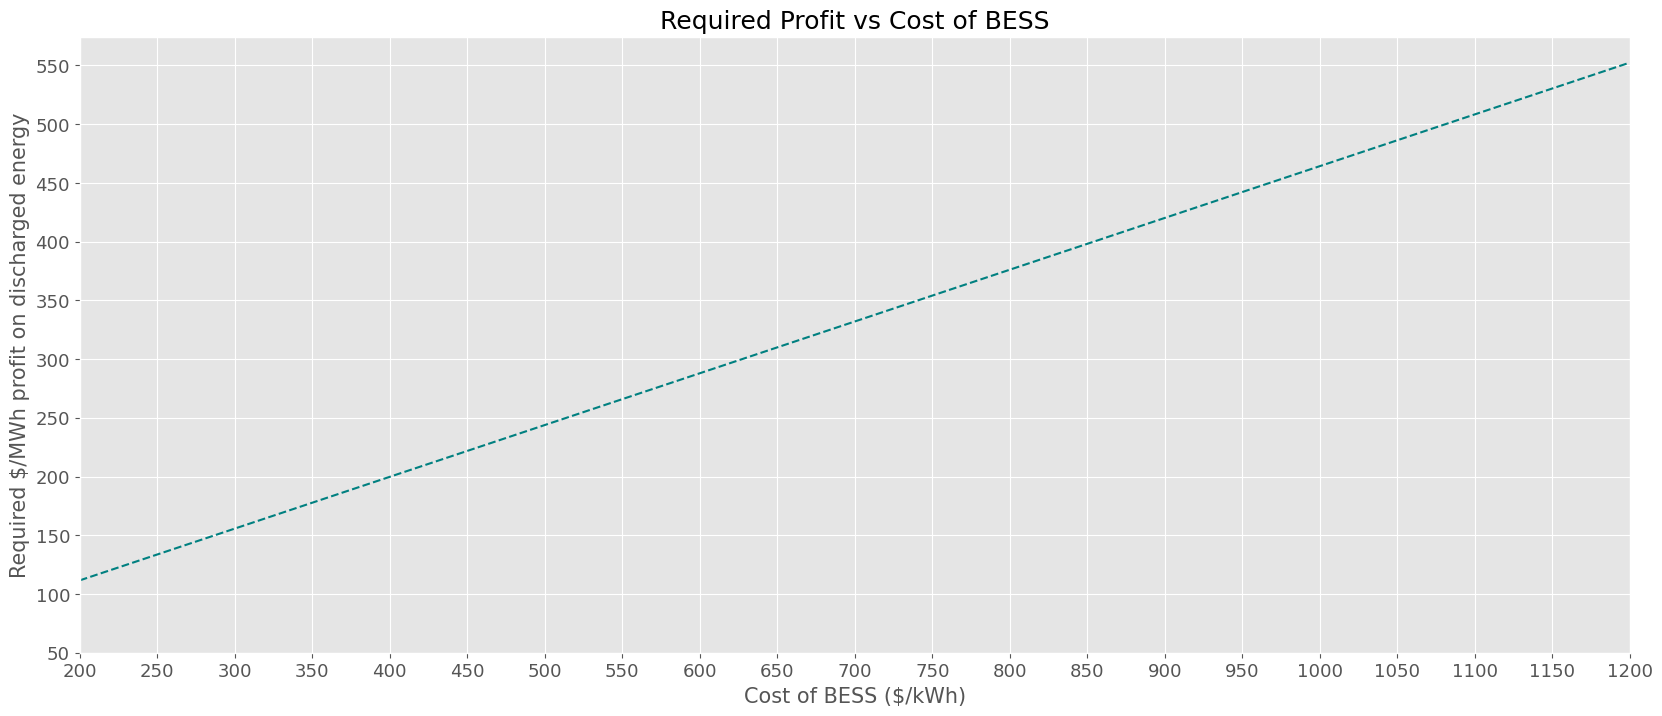

In [24]:
# Range of possible CAPEX values in $/kWh to graph
CAPEX = np.arange(200, 1250, 50)

# Function to calculate the yearly interest repayments
def repayments(capex):
    return ((npf.pmt(params['interest_rate'] / 12, 12 * params['project_duration'], capex * 1000) * 12 * params['project_duration']) + capex * 1000) / params['project_duration']

# Calculate repayments for each CAPEX value
repayments_values = np.array([round(repayments(capex), 2) for capex in CAPEX])

# Create DataFrame for CAPEX and repayments
capex_repayments = pd.DataFrame({
    "CAPEX_$/KWh": CAPEX,
    "Annual_repayments": repayments_values
})

# Add OPEX costs and total annual costs
capex_repayments['OPEX'] = -params['initial_capacity'] * 1000 * params['OPEX']
capex_repayments['Total_annual_costs_$'] = capex_repayments['Annual_repayments'] + capex_repayments['OPEX']

# Calculate capacity for each year
years = np.arange(1, params['project_duration'] + 1)
capacities = params['initial_capacity'] * ((1 - params['degradation_rate']) ** (years - 1))

# Create DataFrame for BESS operation
BESS_operation = pd.DataFrame({
    'Year': years,
    'MWh_Capacity': capacities
})
BESS_operation["Annual_throughput_MWh"] = BESS_operation["MWh_Capacity"] * (params['cycles_per_day'] * 365) * params['DoD']

capex_repayments['Daily_spread_$'] = 0.0
for index, row in capex_repayments.iterrows():
    CAPEX = row['CAPEX_$/KWh']
    # Function to calculate IRR based on daily spread
    def calculate_irr(daily_spread):
        cashflows = pd.DataFrame({"cashflow": [-CAPEX * 1000] + (BESS_operation["Annual_throughput_MWh"] * daily_spread + row["Total_annual_costs_$"]).tolist()})
        irr = npf.irr(cashflows['cashflow'].tolist())
        return irr
    def irr_difference(daily_spread):
        return calculate_irr(daily_spread) - params['IRR']
    
    # Use fsolve to find the daily spread that makes the IRR equal to the goal IRR
    initial_guess = 200  # Initial guess for the daily spread
    required_daily_spread = fsolve(irr_difference, initial_guess)[0]

    capex_repayments.loc[index,"Daily_spread_$"] = required_daily_spread

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(capex_repayments['CAPEX_$/KWh'], capex_repayments['Daily_spread_$'], color='teal', linestyle = "--")
ax.set_xlim(200,1200)
ax.set_xticks(range(int(capex_repayments['CAPEX_$/KWh'].min()), int(capex_repayments['CAPEX_$/KWh'].max()) + 1, 50))
ax.set_xlabel('Cost of BESS ($/kWh)',size=15)
ax.set_yticks(range(50,600,50))
ax.set_ylabel('Required $/MWh profit on discharged energy',size=15)
ax.set_title('Required Profit vs Cost of BESS',size=18)
ax.tick_params(axis='x', labelsize=13) 
ax.tick_params(axis='y', labelsize=13)
ax.grid(True)
plt.show()

## Calculate the charge vs discharge prices for the given CAPEX and IRR

Intercept           23.445726
Q("CAPEX_$/KWh")     0.440819
dtype: float64


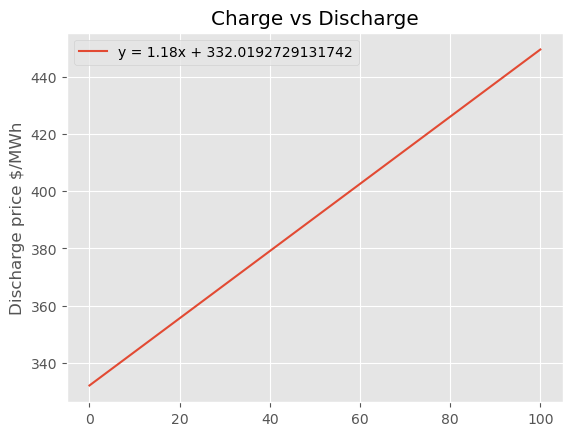

For a $20/MWh charge price a $355.55/MWh is required to get a 12.0% IRR with a capex of $700/kWh


In [27]:
# Calculate the linear equation 
slope = ols('Q("Daily_spread_$") ~ Q("CAPEX_$/KWh")', data=capex_repayments).fit()
print(slope.params)

# Define the linear function
def linear_function(x):
    m = 1/params['RTE']  # slope
    c = (slope.params.iloc[1]*Actual_capex+slope.params.iloc[0])  # y-intercept
    return m * x + c

# Generate x values
x = np.linspace(0, 100, 400)  # Adjust the range and number of points as needed

# Calculate y values
y = linear_function(x)

# Plot the graph
plt.plot(x, y, label=f'y = {round(1/params['RTE'],2)}x + {(slope.params.iloc[1]*Actual_capex+slope.params.iloc[0])}')
plt.ylabel('Discharge price $/MWh')
plt.title(f'Charge vs Discharge')
plt.legend()
plt.grid(True)
plt.show()

discharge_price = 1/params['RTE'] * charge_price_to_test + (slope.params.iloc[1]*Actual_capex+slope.params.iloc[0])
print(f"For a ${charge_price_to_test}/MWh charge price a ${round(discharge_price,2)}/MWh is required to get a {params['IRR']*100}% IRR with a capex of ${Actual_capex}/kWh")

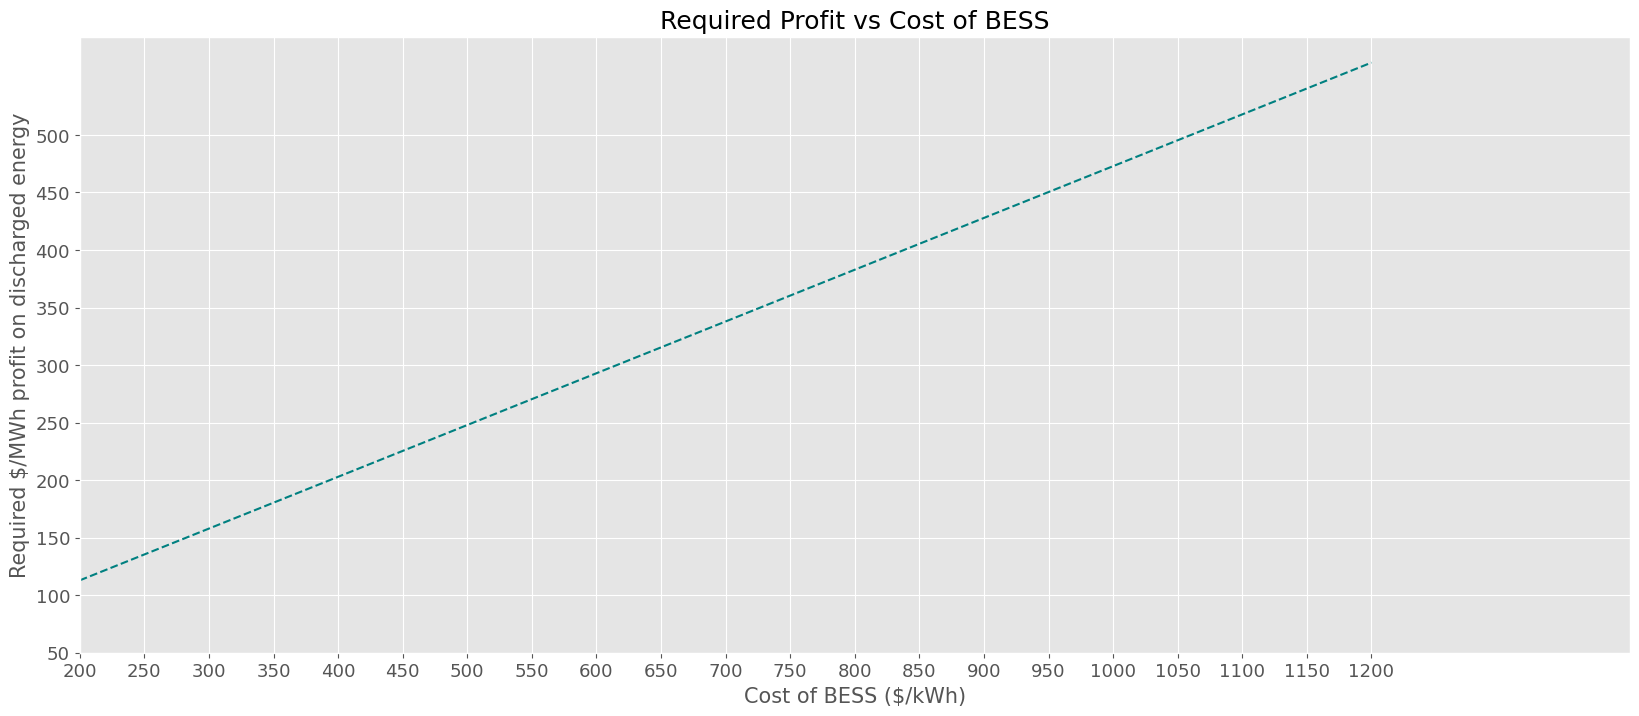

In [2]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(capex_repayments['CAPEX_$/KWh'], capex_repayments['Daily_spread_$'], color='teal', linestyle = "--")
#ax.axhline(221, color='green', linestyle='--', label='VIC absolute best case 2hr average spread since 2020')
#ax.axhline(378, color='orange', linestyle='--', label='SA absolute best case 2hr average spread since 2020')
#ax.axhline(300, color='pink', linestyle='--', label='NSW absolute best case 2hr average spread since 2020')
#ax.axhline(417, color='purple', linestyle='--', label='QLD absolute best case 2hr average spread since 2020')
ax.set_xlim(200,1400)
ax.set_xticks(range(int(capex_repayments['CAPEX_$/KWh'].min()), int(capex_repayments['CAPEX_$/KWh'].max()) + 1, 50))
ax.set_yticks(range(50,550,50))
ax.set_xlabel('Cost of BESS ($/kWh)',size=15)
ax.set_ylabel('Required $/MWh profit on discharged energy',size=15)
ax.set_title('Required Profit vs Cost of BESS',size=18)

ax.tick_params(axis='x', labelsize=13)  # Change the number to your desired font size
ax.tick_params(axis='y', labelsize=13)  # Change the number to your desired font size

ax.grid(True)
plt.show()

In [3]:
capex_repayments_12 = capex_repayments.copy()

In [4]:
capex_repayments_15 = capex_repayments.copy()

In [5]:
capex_repayments_18 = capex_repayments.copy()

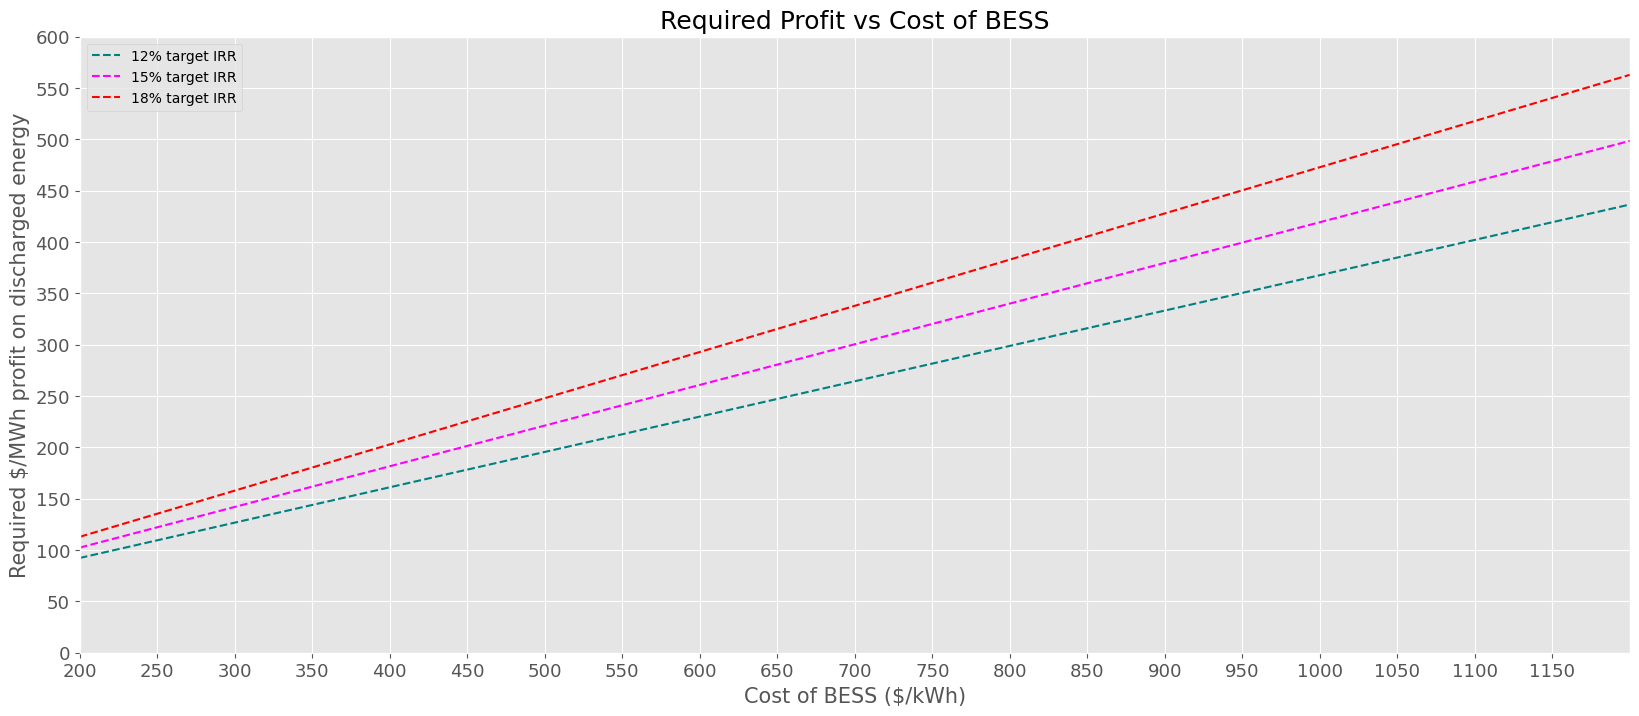

In [123]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(capex_repayments_12['CAPEX_$/KWh'], capex_repayments_12['Daily_spread_$'], color='teal', linestyle = "--",label="12% target IRR")
ax.plot(capex_repayments_15['CAPEX_$/KWh'], capex_repayments_15['Daily_spread_$'], color='magenta', linestyle = "--",label="15% target IRR")
ax.plot(capex_repayments_18['CAPEX_$/KWh'], capex_repayments_18['Daily_spread_$'], color='red', linestyle = "--",label="18% target IRR")
#ax.axhline(300, color='purple', linestyle='--', label='')
ax.set_xlim(200,1200)
ax.set_xticks(range(200, 1200, 50))
ax.set_yticks(range(0,650,50))
ax.set_xlabel('Cost of BESS ($/kWh)',size=15)
ax.set_ylabel('Required $/MWh profit on discharged energy',size=15)
ax.set_title('Required Profit vs Cost of BESS',size=18)

ax.tick_params(axis='x', labelsize=13)  # Change the number to your desired font size
ax.tick_params(axis='y', labelsize=13)  # Change the number to your desired font size

ax.legend()

ax.grid(True)
plt.show()